In [1]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA

In [2]:
#read in data
mb = pd.read_csv("/Users/ajaypatel8/Downloads/Metabolic Syndrome.csv")

In [3]:
#create X and y for modeling
X = mb.drop('MetabolicSyndrome', axis=1)
y = mb['MetabolicSyndrome']

#impute missing values
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

X[numerical_cols] = imputer_num.fit_transform(X[numerical_cols])
X[categorical_cols] = imputer_cat.fit_transform(X[categorical_cols])

In [4]:
#convert categorical columns into numeric form
sex_label_encoder=LabelEncoder()
X["Sex"]=sex_label_encoder.fit_transform(X["Sex"])

marital_label_encoder=LabelEncoder()
X["Marital"]=marital_label_encoder.fit_transform(X["Marital"])

race_label_encoder=LabelEncoder()
X["Race"]=race_label_encoder.fit_transform(X["Race"])

In [5]:
#check for null values, none left so we're good to go
X.isnull().sum()

seqn             0
Age              0
Sex              0
Marital          0
Income           0
Race             0
WaistCirc        0
BMI              0
Albuminuria      0
UrAlbCr          0
UricAcid         0
BloodGlucose     0
HDL              0
Triglycerides    0
dtype: int64

In [6]:
#scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

#make train and test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
#apply PCA to the features
pca = PCA(n_components=3) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [8]:
#initialize logistic regression model
model = LogisticRegression(random_state=42)

# Define hyperparameters for grid search
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
}

# Perform Grid Search with cross-validation
grid_search_lr = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_pca, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search_lr.best_params_)

#get model with best performance
best_lr_model = grid_search_lr.best_estimator_

#perform cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_lr_model, X_train, y_train, cv=cv, scoring='accuracy')

#print the cv scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

#fit the model
best_lr_model.fit(X_train_pca, y_train)

#make predictions
y_pred = best_lr_model.predict(X_test_pca)

#evaluate model by accuracy, f1 score and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-validation scores: [0.87760417 0.8515625  0.84375    0.8046875  0.84635417]
Mean CV accuracy: 0.8447916666666666
Accuracy: 0.8150
F1 Score: 0.6983


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1168, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/l

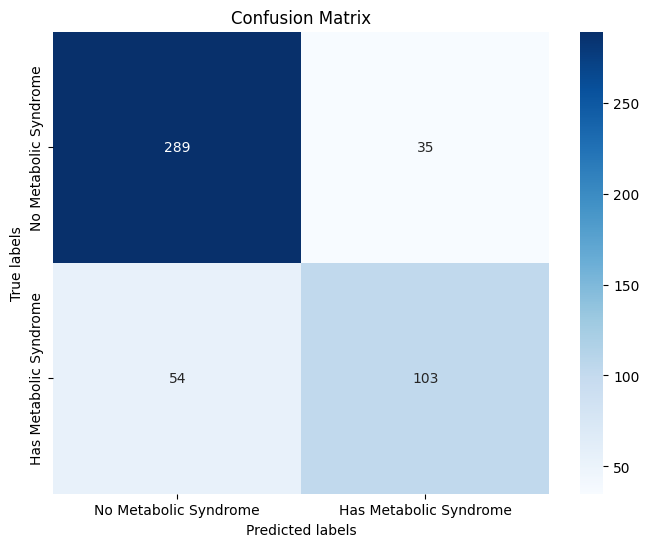

In [9]:
#labels for conf matrix
labels = ['No Metabolic Syndrome', 'Has Metabolic Syndrome']

#plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

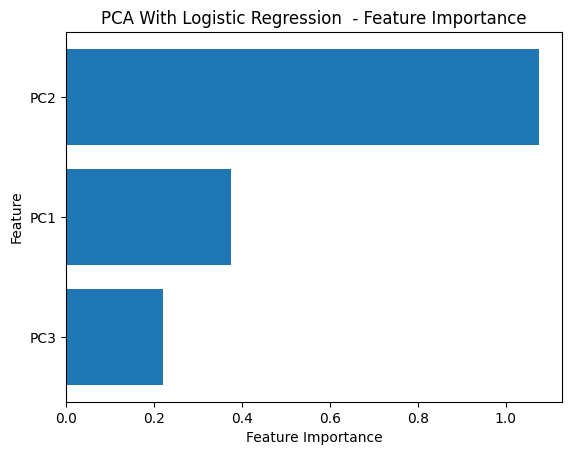

In [14]:
#get feature names and coefficients
feature_names = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
coefficients = best_lr_model.coef_[0]

#get feature importance
feature_importance = abs(coefficients)

#sort feature importance
sorted_feature_importance = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=False)

#visualize feature importance
features, importance = zip(*sorted_feature_importance)
plt.barh(features, importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('PCA With Logistic Regression  - Feature Importance')
plt.show()